<a href="https://colab.research.google.com/github/dcordovacarrizales/xrayanalysis/blob/erika/Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


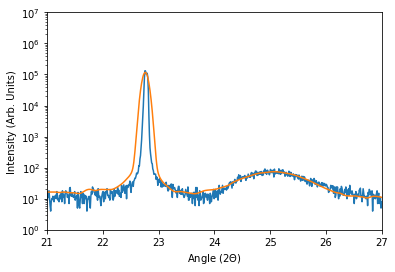

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import ntpath
import math 

from scipy.signal import find_peaks
from bs4 import BeautifulSoup
from google.colab import drive



drive.mount('/content/drive')
infile = '/content/drive/My Drive/Mundy Group/Three Muskateers Group/X-Ray Data/Dan/J465 CaH2 test/J465p6_T01_NdNiO3_STO_2hrs250C_15piecesCaH2.xrdml'
infile2 = '/content/drive/My Drive/Mundy Group/Three Muskateers Group/X-Ray Data/Dan/SrTiO3_001_substrate/SrTiO3_001_substrate.xrdml'


# get kalpha2
def getKalpha2(filename):
  soup = convertToBS(filename)
  return soup.kalpha2.string

# converts xrdml file into BeautifulSoup object
def convertToBS(filename):
  with open(filename,'r') as file:
    file_input = file.read()
  return BeautifulSoup(file_input)

# get 2Theta start and end positions
def get2Theta(filename):
  soup = convertToBS(filename)
  return [float(soup.startposition.string),float(soup.endposition.string)]

# get intensities of tth scan 
def getIntensities(filename):
  soup = convertToBS(filename)
  #print(soup)
  return [float(count) for count in soup.counts.string.split()]

# get id 
def getID(filename):
  soup = convertToBS(filename)
  return soup.id.string

# create dictionary of 2Theta and intensity values
def createDict(filename):
  d = {}
  [tth_beg,tth_end] = get2Theta(filename)
  intensities = getIntensities(filename)
  tth = tth_beg
  incr = (tth_end - tth_beg) / (len(intensities) - 1)
  for i in intensities:
    d[tth] = i
    tth = tth + incr
  return d

#Return peak centers and amplitudes 
def getPeaks(x, y, peaks):
  xVal = x[peaks]
  yVal = y[peaks]
  peakTuple = []
  print(len(peaks))
  for i in range (len(peaks)):
    peakTuple.append((xVal[i], yVal[i]))
  return print(peakTuple)

def gaussianFunc(x,x0,sigma):
  #Return a numpy array gaussian distribution.
  return np.exp(-(x-x0) ** 2 / (2 * sigma ** 2))

def lorentzianFunc(x,x0,tau):
  # Return a numpy array lorentzian distribution.
  return (1 / np.pi) * (1/2 * tau) / ((x-x0) ** 2 + (1/2*tau) ** 2)

def getwidth_incr(x,sigma,std):
  # Return the fwhm and incr for the Smooth function.
  fwhm = sigma * np.sqrt(8 * np.log(2))
  incr = x[1] - x[0]
  ind_incr = int(round(std*fwhm/incr))
  return (ind_incr,fwhm)

def Smooth(x,y,sigma,std,weightG,weightL):
  #Returns the gaussian/lorenztian smoothed data.
  smoothed_vals = np.zeros(y.shape)
  incr,fwhm = getwidth_incr(x,sigma,std)
  x = np.pad(x,incr)
  y = np.pad(y,incr)

  for i in range(len(x)-2*incr):
    gaussian = gaussianFunc(x[i:i+2*incr],x[i+incr],sigma)
    gaussian = gaussian/ sum(gaussian)
    lorentzian = lorentzianFunc(x[i:i+2*incr],x[i+incr],fwhm)
    smoothed_vals[i] = sum(weightG * y[i:i+2*incr] * gaussian + weightL * y[i:i+2*incr] * lorentzian)
  return smoothed_vals

# Returns the file name from a path 
def fileName(file):
    head, tail = ntpath.split(file)
    return tail or ntpath.basename(head)

# Outputs rangeslider style graph including: raw data, smoothed data, and peaks based off of smoothed data for a single dataset 
def rangeSlider(x,y):
  # Loads the data 
  data = {'x': x, 'y':y}
  df = pd.DataFrame(data)

  # Smooth Data
  peaksApprox, _ = find_peaks(Smooth(x,y,0.1, 2, 0.5, 0.5), prominence = 80 )
  xValApprox = x[peaksApprox]
  yValApprox = Smooth(x,y,0.1, 2, 0.5, 0.5)[peaksApprox]

  # Creates the figure
  fig = go.Figure()
  # Adds raw data 
  fig.add_trace(
    go.Scatter(x=list(df.x), y=list(df.y), name = "data")
  )
  
  # Adds the smoothing 
  #fig.add_trace(
   # go.Scatter(x = x, y =Smooth(x,y,0.1, 2, 0.5, 0.5), name = "approximation" )
  #)
  
  #Adds the peaks from the smooth graph
  #fig.add_trace(
   # go.Scatter(x = xValApprox, y =yValApprox, mode='markers', name = "peaks")
  #)

  # Set the title
  fig.update_layout(
    title_text=fileName(infile)
  )
  
  # Add range slider
  fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(label = "all", step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    ),
    yaxis_type="log",
    xaxis_title="2 Theta",
    yaxis_title="Intensity",
  )
  fig.show()
  
# Stacks graphs on top of each other 
def stackGraphs(x1, y1, x2, y2, peakProm):
  # Create figure
  fig = go.Figure()
 
  # Smooth Data
  peaksApprox1, _ = find_peaks(Smooth(x1,y1,0.1, 2, 0.5, 0.5), prominence = int(peakProm))
  xValApprox1 = x1[peaksApprox1]
  yValApprox1 = Smooth(x1,y1,0.1, 2, 0.5, 0.5)[peaksApprox1]

  peaksApprox2, _ = find_peaks(Smooth(x2,y2,0.1, 2, 0.5, 0.5), prominence = int(peakProm))
  xValApprox2 = x2[peaksApprox2]
  yValApprox2 = Smooth(x2,y2,0.1, 2, 0.5, 0.5)[peaksApprox2]

  # Raw Data
  coordinates1, coordinates2 = [], []
  for i in range(len(x1)):
    coordinates1.append((x1[i], y1[i]))
  for i in range(len(x2)):
    coordinates2.append((x2[i], y2[i]))

  coordinates1 = [str(num) for num in coordinates1]
  coordinates2 = [str(num) for num in coordinates2]

  temp1 = x1
  temp2 = y1 - y2
  peaksTemp, _ = find_peaks(Smooth(temp1,temp2,0.1, 2, 0.5, 0.5), prominence = int(peakProm))

  # First Data Trace
  fig.add_trace(go.Scatter(
    x=[str(num) for num in x1],
    y=[str(num) for num in y1],
    name=fileName(infile) + " Raw Data",
    #text=coordinates1,
    yaxis="y"
  ))
  
  # First Smooth Data 
  fig.add_trace(go.Scatter(
    x=x1,
    y=Smooth(x1,y1,0.1, 2, 0.5, 0.5),
    name=fileName(infile) + " Smoothed Data",
    yaxis="y"
  ))

  # First Smooth Peaks 
  fig.add_trace(go.Scatter(
    x=xValApprox1,
    y=yValApprox1,
    name=fileName(infile) +" Peaks",
    yaxis="y",
    mode='markers',
    #text = xValApprox1 
  ))

  #Second Data Trace 
  fig.add_trace(go.Scatter(
    x=[str(num) for num in x2],
    y=[str(num) for num in y2],
    name=fileName(infile2) + " Raw Data",
    #text=coordinates2,
    yaxis="y2",
  ))

  # Second Smooth Data 
  fig.add_trace(go.Scatter(
    x=x_vals2,
    y=Smooth(x2,y2,0.1, 2, 0.5, 0.5),
    name=fileName(infile2) + " Smoothed Data",
    yaxis="y2"
  ))

  # Second Smooth Peaks 
  fig.add_trace(go.Scatter(
    x=xValApprox2,
    y=yValApprox2,
    name=fileName(infile2) + " Peaks",
    yaxis="y2",
    mode='markers',
    #text = xValApprox2 
  ))

  # style all the traces
  fig.update_traces(
      #hoverinfo="text+name",
      line={"width": 0.5},
      marker={"size": 8},
      showlegend=False
  )
  
  # Update axes
  fig.update_layout(
      xaxis=dict(
          autorange=True,
          range=[min([float(num) for num in x1]), max([float(num) for num in x1])],
          rangeslider=dict(
              autorange=True,
              range=[min(x1), max(x1)]
          ),
          type="linear",
          title = '2Theta'
      ),
      yaxis=dict(
          anchor="x",
          autorange=True,
          domain=[0, 0.333333],
          linecolor="#673ab7",
          mirror=True,
          range=[min([float(num) for num in y1]), max([float(num) for num in y1])],
          showline=True,
          side="right",
          tickfont={"color": "#673ab7"},
          tickmode="auto",
          ticks="",
          titlefont={"color": "#673ab7"},
          type="log",
          zeroline=False,
          title = 'Intensity'
      ),
      yaxis2=dict(
          anchor="x",
          autorange=True,
          domain=[0.33333, 0.666666],
          linecolor="#E91E63",
          mirror=True,
          range=[min([float(num) for num in y2]), max([float(num) for num in y2])],
          showline=True,
          side="right",
          tickfont={"color": "#E91E63"},
          tickmode="auto",
          ticks="",
          titlefont={"color": "#E91E63"},
          type="log",
          zeroline=False,
          title = 'Intensity'
      )
  )

  # Updates the layout 
  fig.update_layout(
      dragmode="zoom",
      legend=dict(traceorder="reversed"),
      #height=900,
      template="plotly_white",
      margin=dict(
          t=100,
          b=100
      ),
      autosize = True
  )

  fig.show()

def getFolderAndFile(input):
  info = input.split (",")
  folderNames = []
  fileNames = []
  for i in range(len(info)):
    if (i % 2 != 0):
      fileNames.append(info[i])
    else:
      folderNames.append(info[i])
  return folderNames, fileNames

#ignore
# create dictionary of the folders and files
def createfLoaderDic(input):
  d = {}
  folderNames, fileNames = getFolderAndFile(input)

  for i in range(len(folderNames)):
    #d["fLoader" + str(i + 1)] = googleDriveFileLoader.fileLoader(fileNames[i],folderNames[i])
    d["tth" + str(i + 1)] = (fileLoader(fileNames[i],folderNames[i])).createDict()

  return d
#ignore 
def createXYDic(input):
  d = {}
  
  for i in range(len(input)):
    d["x_vals" + str(i + 1)] = np.array(list((input["tth" + str(i + 1)]).keys()))
    d["y_vals" + str(i + 1)] = np.array(list((input["tth" + str(i + 1)]).values()))
  print(d)


#Return peak centers and amplitudes 
def getPeaks(x, y, peaks):
  xVal = x[peaks]
  yVal = y[peaks]
  peakTuple = []
  print(len(peaks))
  for i in range (len(peaks)):
    peakTuple.append((xVal[i], yVal[i]))
  return print(peakTuple)

def gaussianFunc(x,x0,sigma):
  #Return a numpy array gaussian distribution.
  return np.exp(-(x-x0) ** 2 / (2 * sigma ** 2))

def lorentzianFunc(x,x0,tau):
  # Return a numpy array lorentzian distribution.
  return (1 / np.pi) * (1/2 * tau) / ((x-x0) ** 2 + (1/2*tau) ** 2)

def getwidth_incr(x,sigma,std):
  # Return the fwhm and incr for the Smooth function.
  fwhm = sigma * np.sqrt(8 * np.log(2))
  incr = x[1] - x[0]
  ind_incr = int(round(std*fwhm/incr))
  return (ind_incr,fwhm)

def PseudoVoigt(x,y,sigma,std,eta):
  """Returns the gaussian/lorenztian smoothed data."""
  pseudo_voigt = np.zeros(y.shape)
  incr,fwhm = getwidth_incr(x,sigma,std)
  x = np.pad(x,incr)
  y = np.pad(y,incr)

  for i in range(len(x)-2*incr):
    gaussian = gaussianFunc(x[i:i+2*incr],x[i+incr],sigma)
    gaussian = gaussian/ sum(gaussian)
    lorentzian = lorentzianFunc(x[i:i+2*incr],x[i+incr],fwhm)
    lorentzian = lorentzian/ sum(lorentzian)
    pseudo_voigt[i] = sum(eta * y[i:i+2*incr] * gaussian + (1-eta) * y[i:i+2*incr] * lorentzian)
  return pseudo_voigt


  #TODO: Data Output
def plotSemilogy(x,y):
  plt.semilogy(x,y)
  # plt.semilogy(x,PseudoVoigt(x,y,0.05,2.7,1))
  plt.xlabel(r'Angle (2$\Theta$)')
  plt.ylabel(r'Intensity (Arb. Units)')
  plt.xlim([21,27])
  plt.ylim([1,1e7])

def initializeTheta(x,y,nth_peak,prominence):
  peaks, _ = find_peaks(PseudoVoigt(x_vals,y_vals,0.05,2.7,1), prominence = prominence)
  x0 = x[peaks[nth_peak]]
  yp = y[peaks[nth_peak]]
  sigma = np.random.rand()
  b = 0
  return [x0,yp,sigma,b]

def gradientDescent(theta0,x,y,eta,epsilon,min_x,max_x):
  [x0,yp,sigma,b] = theta0
  prev_J = 0.0
  counts = 0
  N = int(len((np.where(x>min_x) and np.where(x<max_x)[0])))
  while True:
    prev_error = J = 0.0

    # Adjust x0
    while True:
      deltaJ_x0 = 0
      for i in np.where((x_vals>min_x) & (x_vals<max_x))[0]:
        h = (yp / (sigma * np.sqrt(2*np.pi))) * gaussianFunc(x[i],x0,sigma) + b
        COEFF = (yp * (x[i] - x0)/(sigma ** 2 * np.sqrt(2*np.pi))) 
        EXP = np.exp(-(x[i]-x0) ** 2 / (2 * sigma ** 2))
        deltaJ_x0 = deltaJ_x0 + (2/N) * (h - y[i]) * 2 * COEFF * EXP
        J = J + (2/N) * (h - y[i]) ** 2   # (1e-4) scalar prevents J from overflowing
      x0 = x0 - eta * deltaJ_x0
      error = deltaJ_x0 ** 2
      if (abs(error - prev_error) < epsilon):
        break
      prev_error = error

    # Adjust yp 
    prev_error = 0.0
    while True:   
      deltaJ_yp = 0.0
      COEFF = 1 / (sigma * np.sqrt(2*np.pi))
      for i in np.where((x_vals>min_x) & (x_vals<max_x))[0]:
        h = (yp / (sigma * np.sqrt(2*np.pi))) * gaussianFunc(x[i],x0,sigma) + b
        EXP = np.exp(-(x[i]-x0) ** 2 / (2 * sigma ** 2))
        deltaJ_yp = deltaJ_yp + (2/N) * (h - y[i])* COEFF * EXP
        J = J + (2/N) * (h - y[i])**2
      yp = yp - (1e4) * eta * deltaJ_yp
      error = deltaJ_yp ** 2
      if (abs(error - prev_error) < epsilon):
        break
      prev_error = error

    # Adjust sigma
    prev_error = 0.0
    while True:
      deltaJ_sigma = 0
      for i in np.where((x_vals>min_x) & (x_vals<max_x))[0]:
        h = (yp / (sigma * np.sqrt(2*np.pi))) * gaussianFunc(x[i],x0,sigma) + b
        COEFF = (yp / (2 * np.pi)) * (((x[i]-x0) ** 2 / sigma ** 4) - (1 / sigma ** 2))
        EXP = np.exp(-(x[i]-x0) ** 2 / (2 * sigma ** 2))
        deltaJ_sigma = deltaJ_sigma + (2/N) * (h - y[i]) * COEFF * EXP
        J = J + (2/N) * (h - y[i]) ** 2
      sigma = sigma - eta * deltaJ_sigma
      error = deltaJ_sigma ** 2
      if (abs(error - prev_error) < epsilon):
        break
      prev_error = error

    # Adjust b
    prev_error = 0.0
    while True:
      delta_J = 0
      deltaJ_b = 0
      for i in np.where((x_vals>min_x) & (x_vals<max_x))[0]:
        h = (yp / (sigma * np.sqrt(2*np.pi))) * gaussianFunc(x[i],x0,sigma) + b
        deltaJ_b = deltaJ_b  + (2/N) * (h - y[i]) 
        J = J + (2/N) * (h - y[i]) ** 2
      b = b - (1e4) * eta * deltaJ_b
      error = deltaJ_b ** 2
      if (abs(error - prev_error) < epsilon):
        break
      prev_error = error

    if (abs(J - prev_J) < epsilon) or counts > 1000:
      break
    prev_J = J
    counts = counts + 1

  return [x0,yp,sigma,b]

def braggsLaw(n,theta,lbda):
  d = (n * lbda) / (2 * math.sin(math.radians(theta)))
  return '{:.3f}'.format(d)

def txtFile(txtFileMame, distance):
  testFile = open(txtFileMame, "w")
  testFile.write(txtFileMame)
  testFile.write("\n")
  testFile.write("D = " + distance + " Å")
  testFile.close()


#fileFolderInput = input("Enter Folder(s), and File(s) in the Following Format: Folder #1 Name, File #1 Name, Folder #2 Name, File #2 Name ....")
#foldersFiles = createFileFolderDict(fileFolderInput)


tth1 = createDict(infile)
x_vals,y_vals = np.array(list(tth1.keys())),np.array(list(tth1.values()))

tth2 = createDict(infile2)
x_vals2, y_vals2 = np.array(list(tth2.keys())),np.array(list(tth2.values()))


x_vals,y_vals = np.array(list(tth1.keys())),np.array(list(tth1.values()))
x_vals2, y_vals2 = np.array(list(tth2.keys())),np.array(list(tth2.values()))

th0 = initializeTheta(x_vals,y_vals,1,10)
th = gradientDescent(th0,x_vals,PseudoVoigt(x_vals,y_vals,0.05,2.7,1) - PseudoVoigt(x_vals2,y_vals2,0.05,2.7,1),5e-5,0.01,23,27)
[x0,yp,sigma,b] = th
lbda = float(getKalpha2(infile))
plotSemilogy(x_vals,y_vals)
plotSemilogy(x_vals,(yp/ (sigma * np.sqrt(2*np.pi))) * gaussianFunc(x_vals,x0,sigma) + b + PseudoVoigt(x_vals2,y_vals2,0.05,2.7,1))
plt.show()

txtFile(infile.split(".")[0].split('/')[-1], braggsLaw(1,x0,lbda))

#print(getID(infile))
#print(infile)
#peakProminence = input("Enter Prominence for Peaks: ")

#stackGraphs(x_vals,y_vals, x_vals2, y_vals2, peakProminence)

#rangeSlider(x_vals, y_vals)
#rangeSlider(x_vals2, y_vals2)